In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA

In [3]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

In [4]:
# load dataset
dataframe = pd.read_csv('./data/FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                       )
dataframe.head()

,FEDFUNDS
DATE,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.06
1954-10-01,0.85
1954-11-01,0.83


In [5]:
# the index is in datetime format, which is fine
dataframe.index[:5]

DatetimeIndex(['1954-07-01', '1954-08-01', '1954-09-01', '1954-10-01',
               '1954-11-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [6]:
series = pd.read_csv('./data/FEDFUNDS.csv',
                        index_col='DATE',
                        dtype={'FEDFUNDS': np.float32},
                        parse_dates=True, 
                        date_parser=lambda date: pd.datetime.strptime(date, '%Y-%m-%d'),
                        squeeze = True
                       )
series.head()

DATE
1954-07-01   0.80
1954-08-01   1.22
1954-09-01   1.06
1954-10-01   0.85
1954-11-01   0.83
Name: FEDFUNDS, dtype: float32

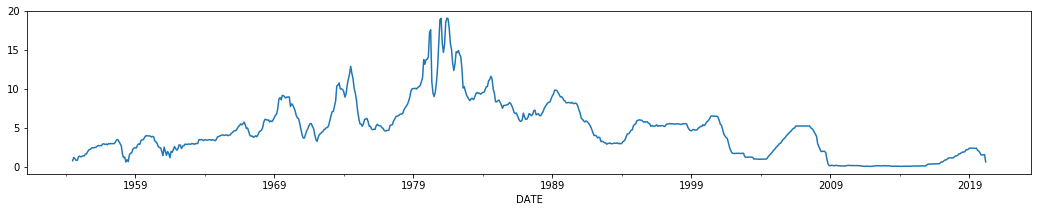

In [7]:
series.plot()

In [8]:
# query a dataset using a date-time index
series[:'2007'].tail(10)

DATE
2007-03-01   5.26
2007-04-01   5.25
2007-05-01   5.25
2007-06-01   5.25
2007-07-01   5.26
2007-08-01   5.02
2007-09-01   4.94
2007-10-01   4.76
2007-11-01   4.49
2007-12-01   4.24
Name: FEDFUNDS, dtype: float32

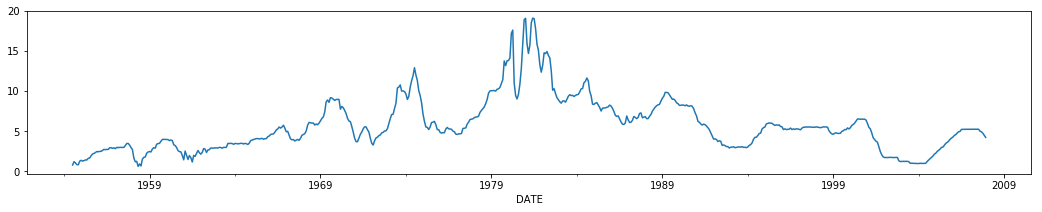

In [9]:
# keep only data before 2008 
series = series[:'2007']
series.plot()

In [10]:
series.describe()

count   642.00
mean      5.69
std       3.32
min       0.63
25%       3.29
50%       5.25
75%       7.30
max      19.10
Name: FEDFUNDS, dtype: float64

In [11]:
# Basic Feature Engineering - DateTime features

datetime_df = pd.DataFrame()
datetime_df['Year'] = series.index.year
datetime_df['Month'] = series.index.month
datetime_df['value'] = series.values.tolist()
datetime_df.head()

,Year,Month,value
0,1954,7,0.80
1,1954,8,1.22
2,1954,9,1.06
3,1954,10,0.85
4,1954,11,0.83


In [12]:
# Basic Feature Engineering - Lag features

values = pd.DataFrame(series)
lag_df = pd.concat([values.shift(3), values.shift(2), values.shift(1), values], axis=1)
lag_df.columns = ['t-2', 't-1', 't', 't+1']
print(lag_df.head())
lag_df.tail()

            t-2  t-1    t  t+1
DATE                          
1954-07-01  nan  nan  nan 0.80
1954-08-01  nan  nan 0.80 1.22
1954-09-01  nan 0.80 1.22 1.06
1954-10-01 0.80 1.22 1.06 0.85
1954-11-01 1.22 1.06 0.85 0.83


,t-2,t-1,t,t+1
DATE,,,,
2007-08-01,5.25,5.25,5.26,5.02
2007-09-01,5.25,5.26,5.02,4.94
2007-10-01,5.26,5.02,4.94,4.76
2007-11-01,5.02,4.94,4.76,4.49
2007-12-01,4.94,4.76,4.49,4.24


In [13]:
# Basic Feature Engineering - Rolling Window features

values = pd.DataFrame(series)
shifted = values.shift(1)
window = shifted.rolling(window=2)
means = window.mean()

rolling_df = pd.concat([means, values], axis=1)
rolling_df.columns = ['mean(t-1,t)', 't+1']
print(rolling_df.head())
rolling_df.tail()

            mean(t-1,t)  t+1
DATE                        
1954-07-01          nan 0.80
1954-08-01          nan 1.22
1954-09-01         1.01 1.06
1954-10-01         1.14 0.85
1954-11-01         0.95 0.83


,"mean(t-1,t)",t+1
DATE,,
2007-08-01,5.26,5.02
2007-09-01,5.14,4.94
2007-10-01,4.98,4.76
2007-11-01,4.85,4.49
2007-12-01,4.62,4.24


In [14]:
values = pd.DataFrame(series)
window_width = 3
shifted = values.shift(window_width - 1)
window = shifted.rolling(window=window_width)

window_width_df = pd.concat([window.min(), window.mean(), window.max(), values], axis=1)
window_width_df.columns = ['min', 'mean', 'max', 't+1']
print(window_width_df.head())
window_width_df.tail()

            min  mean  max  t+1
DATE                           
1954-07-01  nan   nan  nan 0.80
1954-08-01  nan   nan  nan 1.22
1954-09-01  nan   nan  nan 1.06
1954-10-01  nan   nan  nan 0.85
1954-11-01 0.80  1.03 1.22 0.83


,min,mean,max,t+1
DATE,,,,
2007-08-01,5.25,5.25,5.25,5.02
2007-09-01,5.25,5.25,5.26,4.94
2007-10-01,5.02,5.18,5.26,4.76
2007-11-01,4.94,5.07,5.26,4.49
2007-12-01,4.76,4.91,5.02,4.24


In [15]:
####### DATA VISUALIZATION

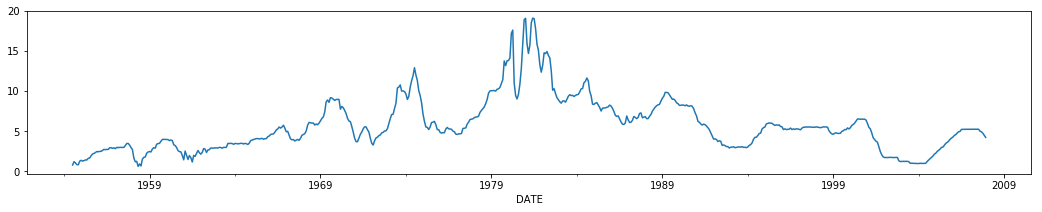

In [16]:
#line plot
series.plot()

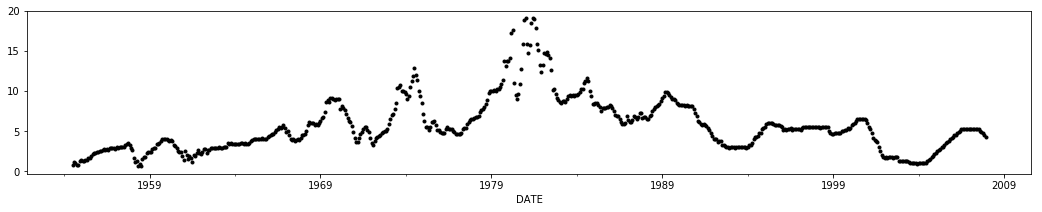

In [17]:
series.plot(style='k.')

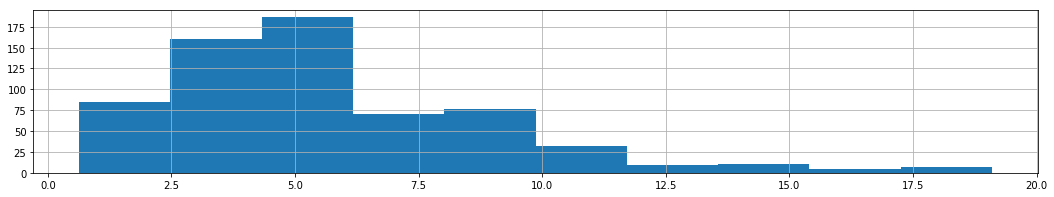

In [18]:
#distribution plot
series.hist()

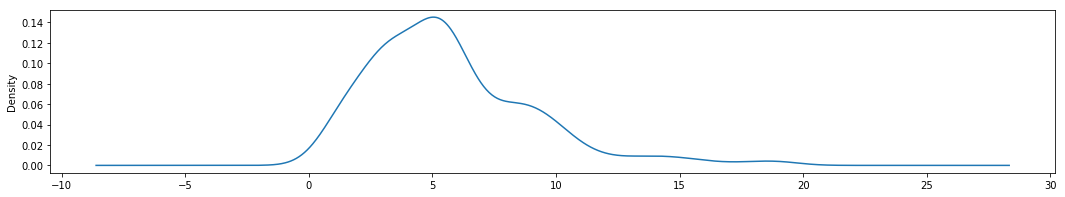

In [19]:
#kde distribution
series.plot(kind='kde')

In [20]:
#Box and whisker plots - to find the distribution of values by time interval (using TimeGrouper) - to summarize the distribution

years, index = [], []
for name, gr in series.groupby(Grouper(freq='A')):
    years.append(gr.values)
    index.append(name.year)
box_df = pd.DataFrame(years, index=index, columns=range(1,13))
box_df.head(10)

,1,2,3,4,5,6,7,8,9,10,11,12
1954,0.80,1.22,1.06,0.85,0.83,1.28,nan,nan,nan,nan,nan,nan
1955,1.39,1.29,1.35,1.43,1.43,1.64,1.68,1.96,2.18,2.24,2.35,2.48
1956,2.45,2.50,2.50,2.62,2.75,2.71,2.75,2.73,2.95,2.96,2.88,2.94
1957,2.84,3.00,2.96,3.00,3.00,3.00,2.99,3.24,3.47,3.50,3.28,2.98
1958,2.72,1.67,1.20,1.26,0.63,0.93,0.68,1.53,1.76,1.80,2.27,2.42
1959,2.48,2.43,2.80,2.96,2.90,3.39,3.47,3.50,3.76,3.98,4.00,3.99
1960,3.99,3.97,3.84,3.92,3.85,3.32,3.23,2.98,2.60,2.47,2.44,1.98
1961,1.45,2.54,2.02,1.49,1.98,1.73,1.17,2.00,1.88,2.26,2.61,2.33
1962,2.15,2.37,2.85,2.78,2.36,2.68,2.71,2.93,2.90,2.90,2.94,2.93
1963,2.92,3.00,2.98,2.90,3.00,2.99,3.02,3.49,3.48,3.50,3.48,3.38


In [21]:
#comparing 1955 values with box_df
series['1955']

DATE
1955-01-01   1.39
1955-02-01   1.29
1955-03-01   1.35
1955-04-01   1.43
1955-05-01   1.43
1955-06-01   1.64
1955-07-01   1.68
1955-08-01   1.96
1955-09-01   2.18
1955-10-01   2.24
1955-11-01   2.35
1955-12-01   2.48
Name: FEDFUNDS, dtype: float32

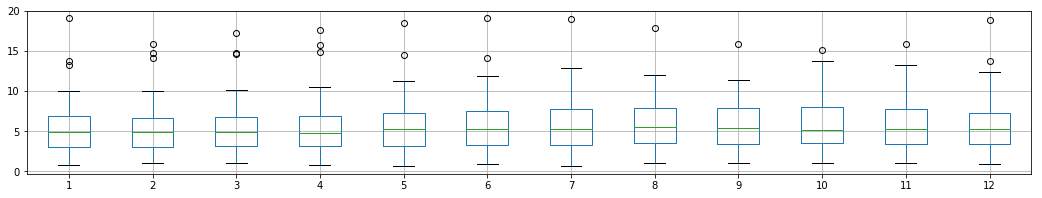

In [22]:
box_df.boxplot() #provide month plot of all years

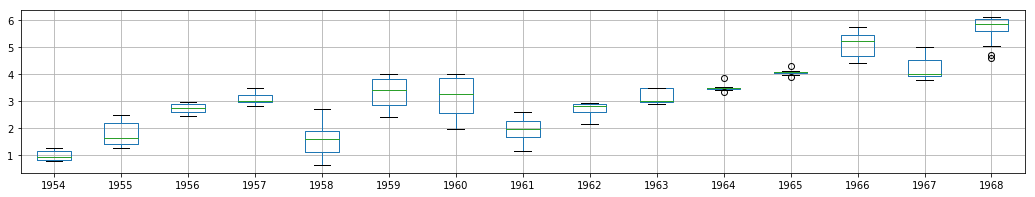

In [23]:
# for yearly plots
box_df.head(15).T.boxplot()

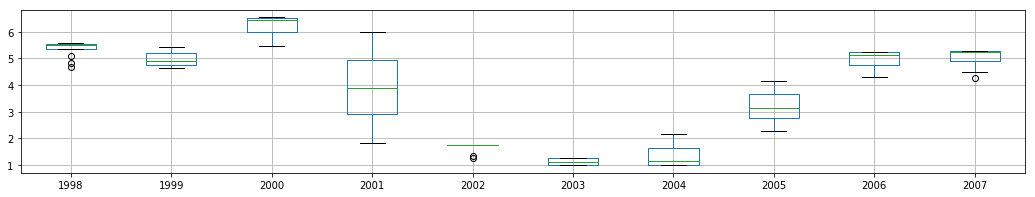

In [24]:
box_df.tail(10).T.boxplot()

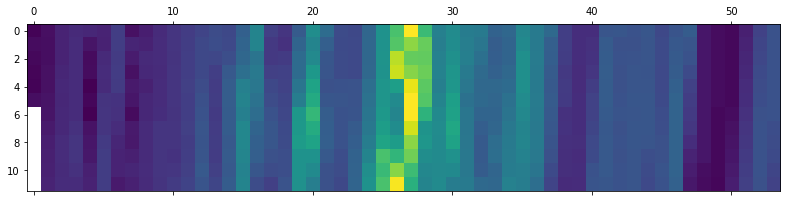

In [25]:
#heat map
plt.matshow(box_df.T, interpolation=None, aspect='auto')

#demonstrates the highers rates in the middle around 1979 - 1982

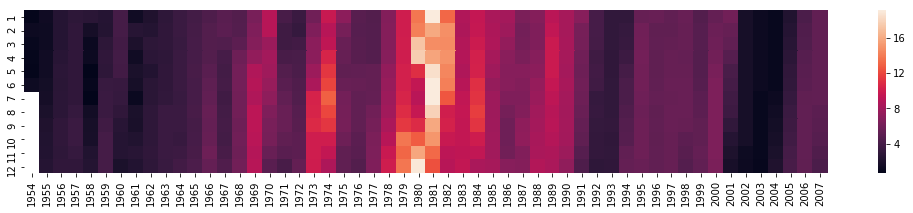

In [26]:
#heat map using seaborn package
sns.heatmap(box_df.T)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  app.launch_new_instance()


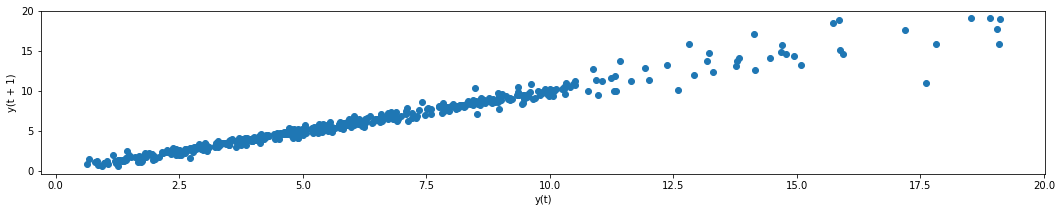

In [27]:
#Lag scatter plots - plots the observation at time t on the x-axis and the lag=1 observation (t-1) on the y-axis.

lag_plot(series)

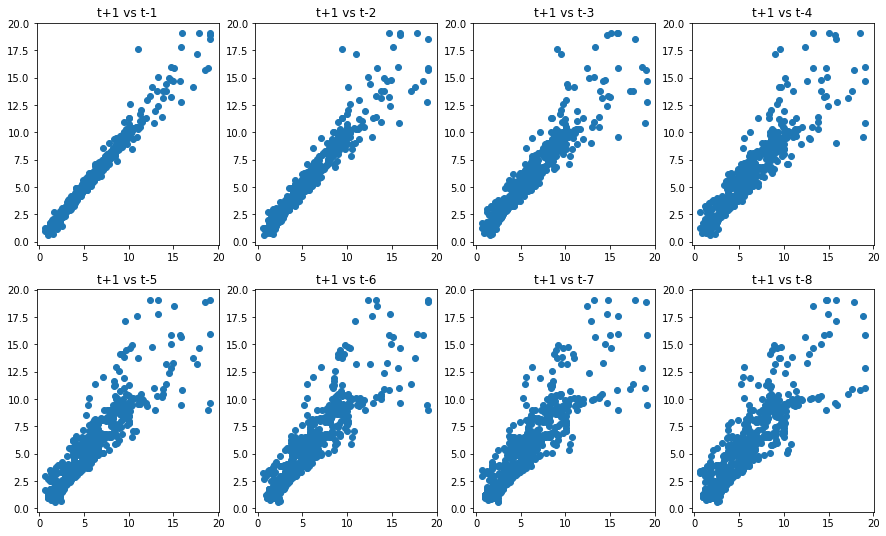

In [32]:
# create multiple scatter plots
values = pd.DataFrame(series)
lags = 8
columns = [values]

for i in range(1,(lags + 1)):
    columns.append(values.shift(i))

df = pd.concat(columns, axis=1)
columns = ['t+1']

for i in range(1,(lags + 1)):
    columns.append('t-' + str(i))
df.columns = columns

plt.figure(1, figsize=(15,9))
for i in range(1,(lags + 1)):
    ax = plt.subplot(240 + i)
    ax.set_title('t+1 vs t-' + str(i))
    plt.scatter(x=df['t+1'].values, y=df['t-'+str(i)].values)
    
#shows that the recent data (or lag) is highly correlated with the data at current time-step or future time-steps

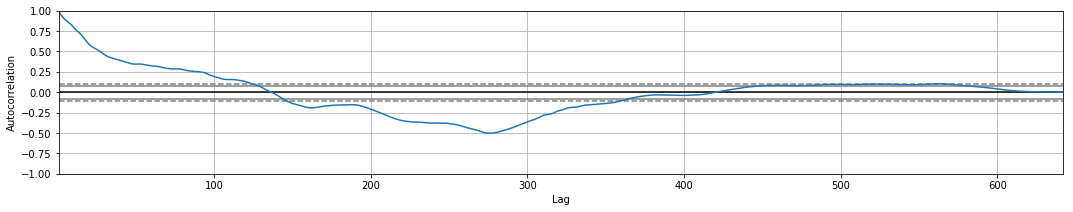

In [34]:
# create an autocorrelation (self-correlation) plot
autocorrelation_plot(series)

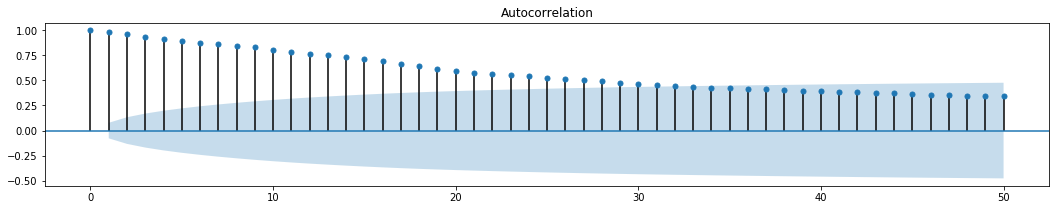

In [36]:
# autocorrelation plot of time series as a line plot
plot_acf(series, lags=50)
plt.show()

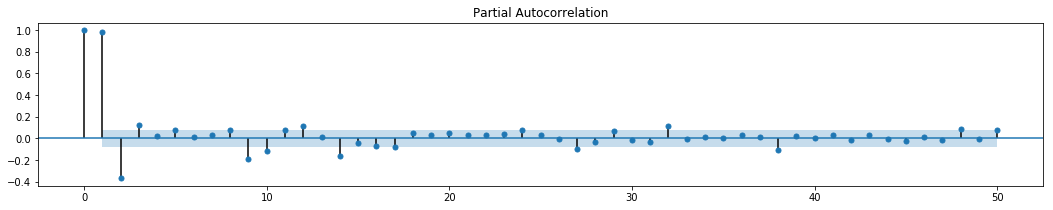

In [41]:
#partial autocorrelation plot 
plot_pacf(series, lags=50)
plt.show()

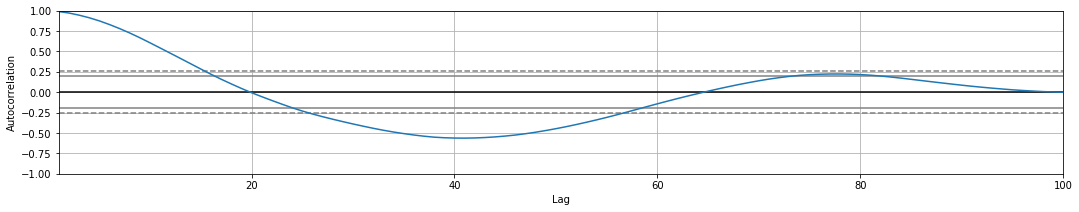

In [37]:
# create an autocorrelation plot, using only the last 100 entries
autocorrelation_plot(series[-100:])

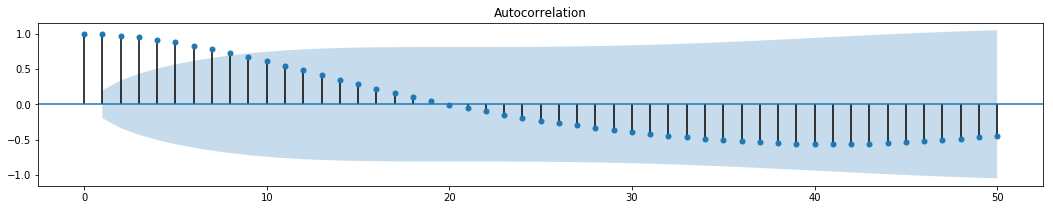

In [38]:
# autocorrelation plot of time series as a line plot
plot_acf(series[-100:], lags=50)
plt.show()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


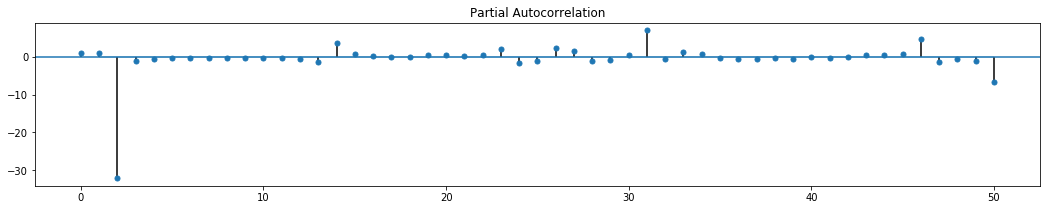

In [42]:
#partial autocorrelation plot of time series as a line plot
plot_pacf(series[-100:], lags=50)
plt.show()

In [45]:
# MOVING AVERAGE SMOOTHING
# naive and effective technique used for data preparation, feature engineering, and even directly for making predictions. 
# Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. 
# hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

# tail-rolling average transform
rolling = series.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean.head(10)

DATE
1954-07-01    nan
1954-08-01    nan
1954-09-01   1.03
1954-10-01   1.04
1954-11-01   0.91
1954-12-01   0.99
1955-01-01   1.17
1955-02-01   1.32
1955-03-01   1.34
1955-04-01   1.36
Name: FEDFUNDS, dtype: float64

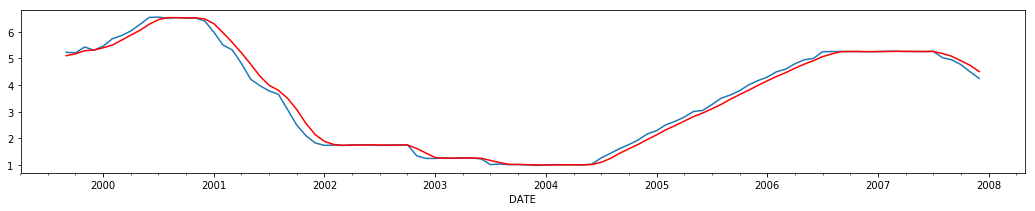

In [46]:
# plot original and transformed dataset
series[-100:].plot()
rolling_mean[-100:].plot(color='red')

In [57]:
## MOVING AVERAGE AS PREDICTION
#a naive model used as a baseline. It assumes that the trend and seasonality components of the time series have already been removed or adjusted for. 
#The moving average model for predictions can easily be used in a walk-forward manner. As new observations are made available (e.g. daily), the model can be updated and a prediction made for the next day.

X = series.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = []

# walk forward over time steps in test
for t in range(len(test)):
    length = len(history)
    yhat = np.mean([history[i] for i in range(length-window,length)])
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
rmse = np.sqrt(mean_squared_error(test, predictions))
r2 = r2_score(test,predictions)
print('RMSE: %.3f' % rmse)
print('R Squared: %.3f' % r2)

RMSE: 0.817
R Squared: 0.939


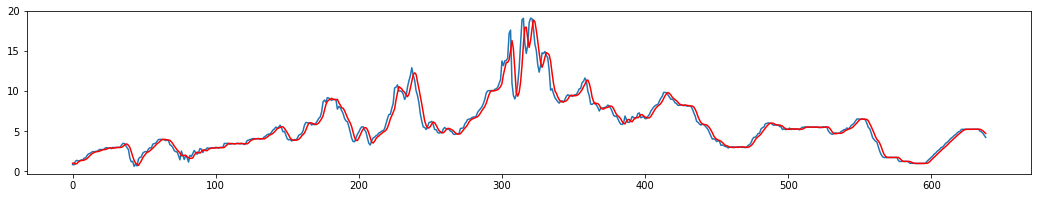

In [58]:
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

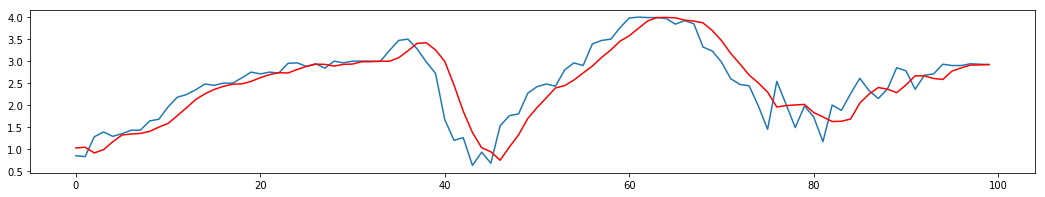

In [60]:
# zoom plot
plt.plot(test[:100])
plt.plot(predictions[:100], color='red')
plt.show()

In [61]:
#Stationary tests - just by the plot we can say that this time series is not stationary. Let's prove it with some tests

#mean and variance test
def mean_and_variance(X):
    split = int(len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    mean1, mean2 = X1.mean(), X2.mean()
    var1, var2 = X1.var(), X2.var()
    print('mean1=%f, mean2=%f' % (mean1, mean2))
    print('variance1=%f, variance2=%f' % (var1, var2))
    
mean_and_variance(series.values)
#very little difference in mean and variance values, so it could be stationary but let's confirm it with unit root ADF test

mean1=5.358878, mean2=6.021246
variance1=11.235865, variance2=10.614982


In [62]:
#unit root test for stationarity :- Augmented Dickey Fuller test

def fuller_test(X):
    result = adfuller(X)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))
        
fuller_test(series.values)

#We can see that our statistic value of -3.185 is less than the value of -2.866 at 5%. This suggests that we can reject the null hypothesis with a significance level of less than 5% (i.e. a low probability that the result is a statistical fluke). 
#Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

ADF Statistic: -3.185298
p-value: 0.020852
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569


In [ ]:
### EVALUATE MODELS
#  k-fold cross-validation does not work in the case of time series data as it ignores the temporal components inherent in the problem.
# In time series forecasting, this evaluation of models on historical data is called backtesting and there are 3 different methods that you can use to backtest your time series problems

In [64]:
# TRAIN-TEST SPLIT
X = series.values
train_size = int(len(X) * 0.66)
train, test = X[0:train_size], X[train_size:len(X)]

print('Observations: %d' % (len(X)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 642
Training Observations: 423
Testing Observations: 219


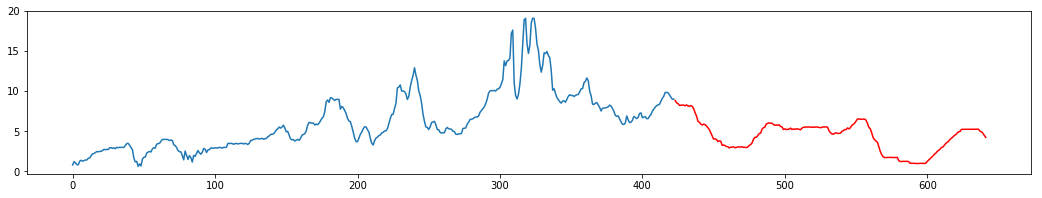

In [67]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r')

Observations: 322
Training Observations: 162
Testing Observations: 160
-----
Observations: 482
Training Observations: 322
Testing Observations: 160
-----
Observations: 642
Training Observations: 482
Testing Observations: 160
-----


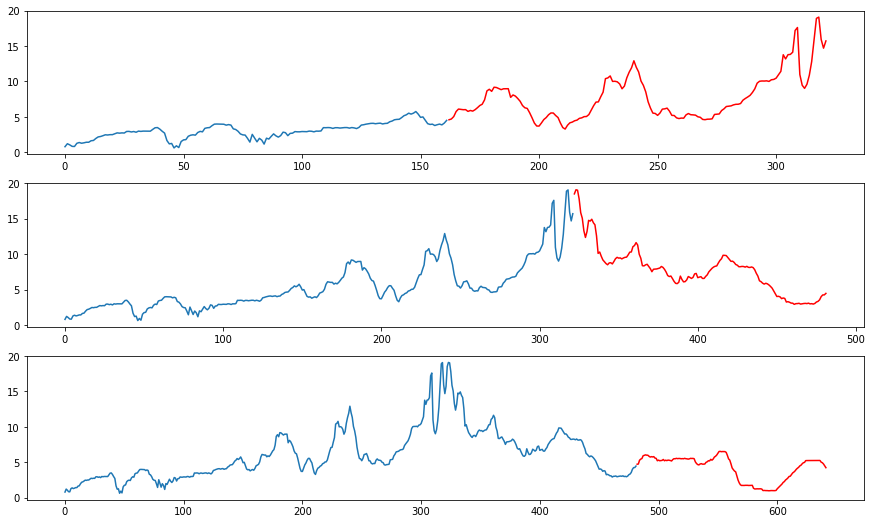

In [69]:
# MULTIPLE TRAIN-TEST SPLITS
# calculate repeated train-test splits of time series data
X = series.values
splits = TimeSeriesSplit(n_splits=3)
index = 1
plt.figure(1, figsize=(15,9))

for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]

    print('Observations: %d' % (len(train) + len(test)))
    print('Training Observations: %d' % (len(train)))
    print('Testing Observations: %d\n-----' % (len(test)))

    plt.subplot(310 + index)
    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test], color='r')
    index += 1

In [71]:
#WALK-FORWARD VALIDATION

# walk forward validation: the train set expanding each time step and the test set fixed at one time step ahead
X = series[-100:].values
n_train = 80
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print('train=%d, test=%d' % (len(train), len(test)))

train=80, test=1
train=81, test=1
train=82, test=1
train=83, test=1
train=84, test=1
train=85, test=1
train=86, test=1
train=87, test=1
train=88, test=1
train=89, test=1
train=90, test=1
train=91, test=1
train=92, test=1
train=93, test=1
train=94, test=1
train=95, test=1
train=96, test=1
train=97, test=1
train=98, test=1
train=99, test=1


In [74]:
# Naive or Persistence model - Baseline
values = pd.DataFrame(series)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']

X = df.values
train_size = int(len(X) * 0.66)
train, test = X[1:train_size], X[train_size:]

train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

def model_persistence(x):
    return x

# walk-forward validation
predictions = []
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
rmse = np.sqrt(mean_squared_error(test_y, predictions))
r2 = r2_score(test_y,predictions)
print('RMSE: %.3f' % rmse)
print('R Squared: %.3f' % r2)

RMSE: 0.187
R Squared: 0.990


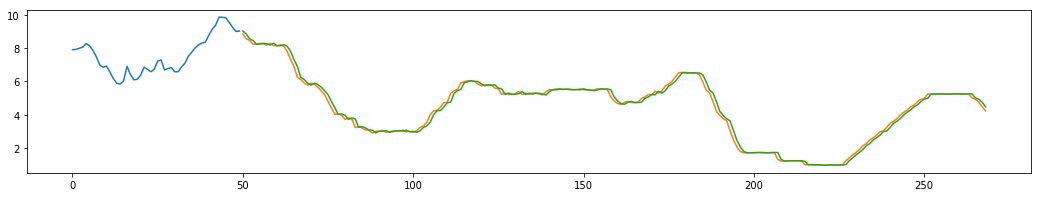

In [75]:
# plot predictions and expected results on the test data
plt.plot(train_y[-50:])
plt.plot([None for i in train_y[-50:]] + [x for x in test_y])
plt.plot([None for i in train_y[-50:]] + [x for x in predictions])

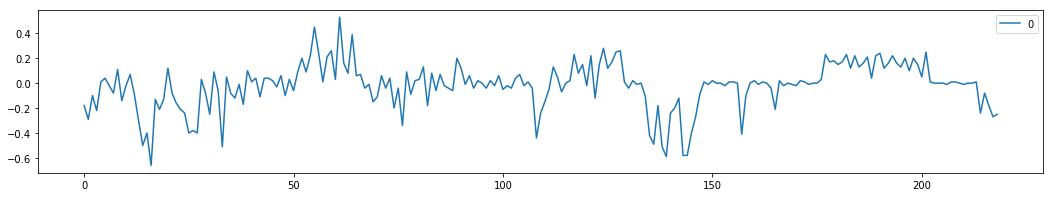

In [76]:
# calculate and visualize residuals from the above persistence model
residuals = [test_y[i]-predictions[i] for i in range(len(predictions))]
residuals = pd.DataFrame(residuals)
residuals.plot()

In [77]:
residuals.describe()

,0
count,219.00
mean,-0.02
std,0.19
min,-0.66
25%,-0.09
50%,0.00
75%,0.08
max,0.53


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f50b0313208>]],
      dtype=object)

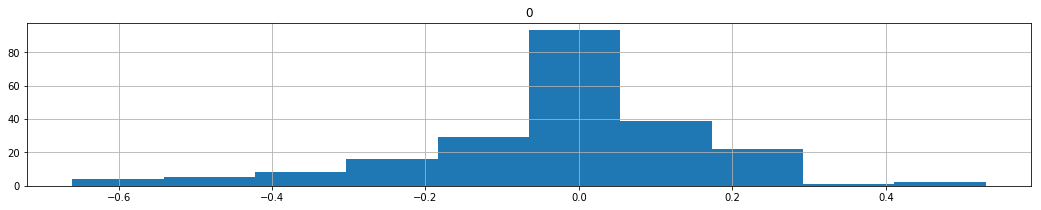

In [80]:
residuals.hist()

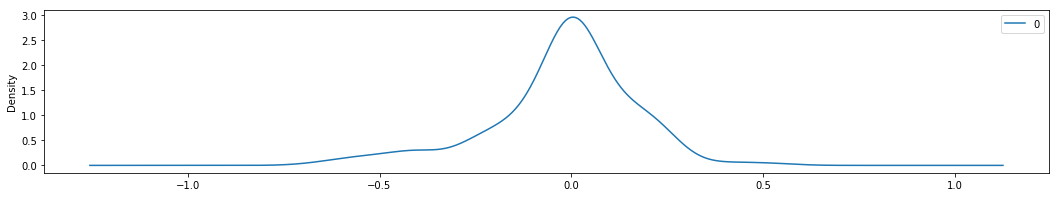

In [81]:
residuals.plot(kind='kde')
#normal distribution implies that most of the correlation is captured, let's confirm with autocorrelation plot

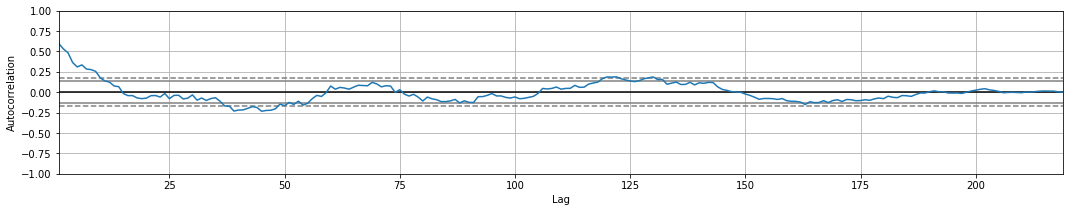

In [85]:
autocorrelation_plot(residuals)
#We would not expect there to be any correlation between the residuals. This would be shown by autocorrelation scores being below the threshold of significance (dashed and dotted horizontal lines on the plot). 
#A significant autocorrelation in the residual plot suggests that the model could be doing a better job of incorporating the relationship between observations and lagged observations, called autoregression.

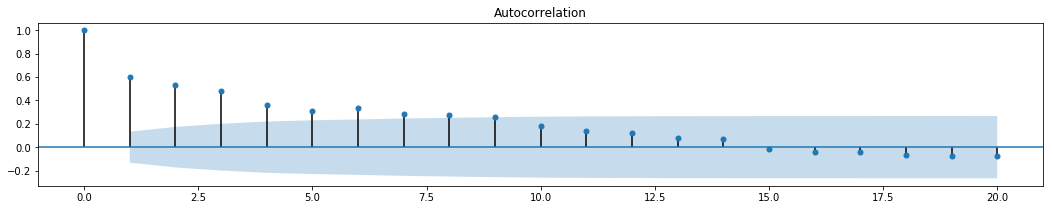

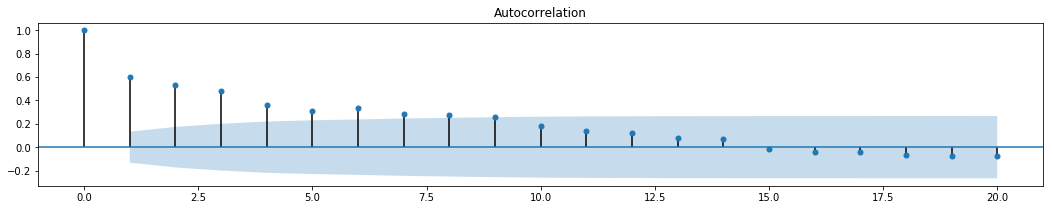

In [82]:
plot_acf(residuals, lags=20)
##very less number of lags display correlation => very less correlation (or patterns) is not captured

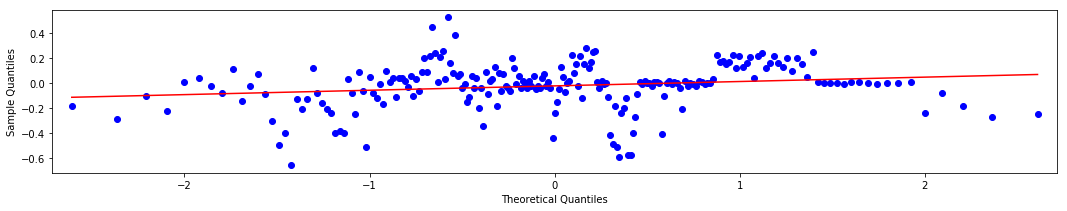

In [83]:
# Q-q or quantile plot -  used to quickly check the normality of the distribution of residual errors
#used to compare distributions: a match between the two distributions is shown as a diagonal line from the bottom left to the top-right of the plot.
qqplot(residuals, line='r')
plt.show()

In [93]:
#TIME SERIES TO CLASSIFICATION - REFRAMING OF A PROBLEM

values = pd.DataFrame(series)
df = pd.concat([values.shift(1), values], axis=1)
df.columns = ['t', 't+1']


def make_discrete(row):
   if row['t+1'] < 0:
      return 'low'
   elif row['t+1'] > 3:
      return 'high'
   else:
      return 'medium'
    
# apply the above function to reassign t+1 values
df['Class'] = df.apply(lambda row: make_discrete(row), axis=1)

# Randomly sample 10 elements from the dataframe
df.sample(n=10)

,t,t+1,Class
DATE,,,
2001-05-01,4.80,4.21,high
1987-11-01,7.29,6.69,high
1976-11-01,5.02,4.95,high
2001-12-01,2.09,1.82,medium
1996-10-01,5.30,5.24,high
1964-12-01,3.52,3.85,high
1958-01-01,2.98,2.72,medium
1967-10-01,3.99,3.88,high
2004-05-01,1.00,1.00,medium


In [95]:
#ARIMA
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/nbuser/anaconda3_501/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:             D.FEDFUNDS   No. Observations:                  641
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -461.593
Method:                       css-mle   S.D. of innovations              0.497
Date:                Mon, 13 Apr 2020   AIC                            937.186
Time:                        03:31:21   BIC                            968.427
Sample:                    08-01-1954   HQIC                           949.312
                         - 12-01-2007                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0057      0.024      0.236      0.813      -0.042       0.053
ar.L1.D.FEDFUNDS     0.4299      0.040     10.882      0.000       0.352       0.507
ar.L2.D.FEDFUNDS    -0.1598      0.043     -3.729      0.000      -0.244      -0.076
ar.L3.D.FEDFUNDS     0.0092      0.043      0.212      0.832      -0.076       0.094
ar.L4.D.FEDFUNDS    -0.0895      0.043     -2.093      0.037      -0.173      -0.006
ar.L5.D.FEDFUNDS    -0.0026      0.039     -0.067      0.947      -0.080       0.075
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1632           -1.0576j            1.5721           -0.1174
AR.2            1.1632           +1.0576j            1.5721            0.1174
AR.3           -1.0840           -1.8229j            2.1208           -0.3354
AR.4           -1.0840           +1.8229j            2.1208            0.3354
AR.5          -34.0576           -0.0000j           34.0576           -0.5000
-----------------------------------------------------------------------------
"""

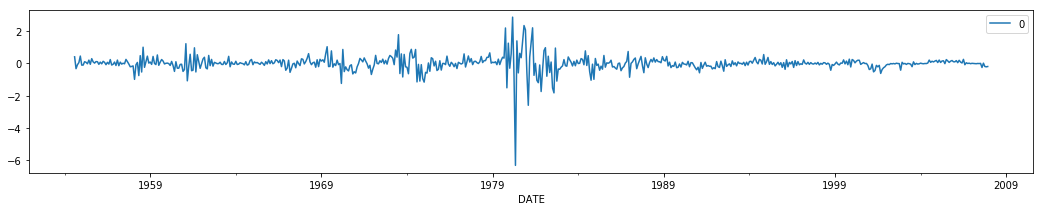

In [96]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

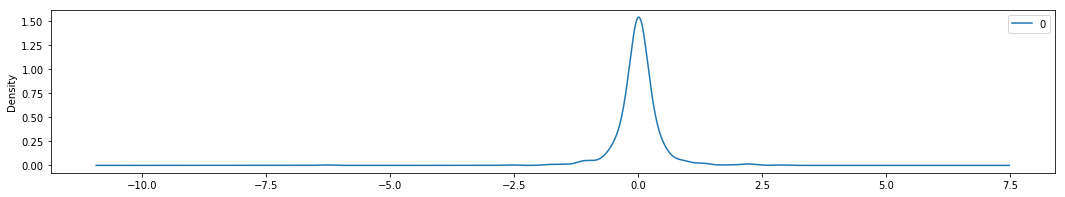

In [97]:
residuals.plot(kind='kde')

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


[(-2, 2)]

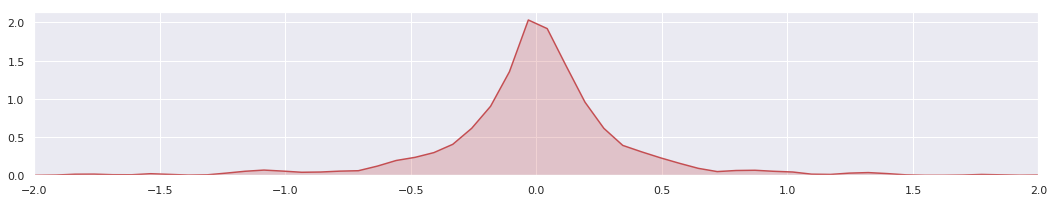

In [98]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

In [99]:
#Rolling forecast ARIMA model
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

In [100]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

In [101]:
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
r2 = r2_score(test,predictions)
print('RMSE: %.3f' % rmse)
print('R Squared: %.3f' % r2)

RMSE: 0.175
R Squared: 0.991


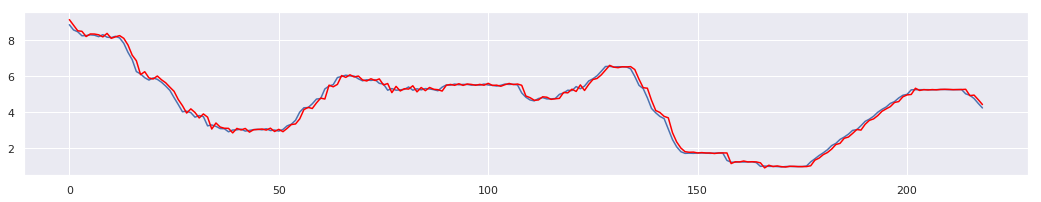

In [102]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red')

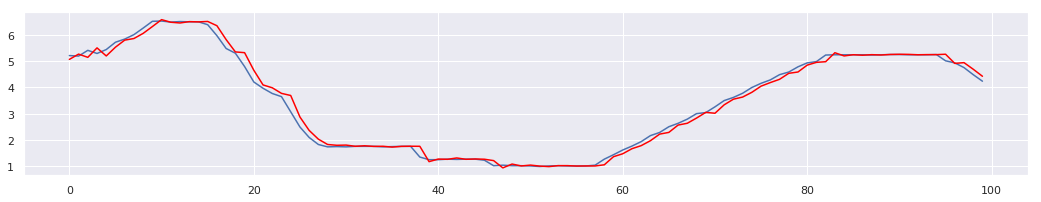

In [103]:
# zoom plot
plt.plot(test_y[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

In [104]:
# auto.arima in Python - Grid search ARIMA model hyperparameters

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]

    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    rmse = np.sqrt(mean_squared_error(test, predictions))
    return rmse

In [105]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue
    
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [107]:
# evaluate parameters
import warnings
warnings.filterwarnings("ignore")

p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1]

evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=2.435
ARIMA(0, 0, 1) RMSE=1.268
ARIMA(0, 1, 0) RMSE=0.189
ARIMA(0, 1, 1) RMSE=0.165
ARIMA(1, 0, 0) RMSE=0.187
ARIMA(1, 0, 1) RMSE=0.165
ARIMA(1, 1, 0) RMSE=0.157
ARIMA(1, 1, 1) RMSE=0.163
ARIMA(2, 0, 0) RMSE=0.157
ARIMA(2, 0, 1) RMSE=0.163
ARIMA(2, 1, 0) RMSE=0.168
ARIMA(2, 1, 1) RMSE=0.177
Best ARIMA(1, 1, 0) RMSE=0.157


In [108]:
#ARIMA(1, 1, 0) performed best and we select it for our final model.

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = []

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
    
# evaluate forecasts
rmse = np.sqrt(mean_squared_error(test, predictions))
r2 = r2_score(test,predictions)
print('RMSE: %.3f' % rmse)
print('R Squared: %.3f' % r2)

RMSE: 0.157
R Squared: 0.993


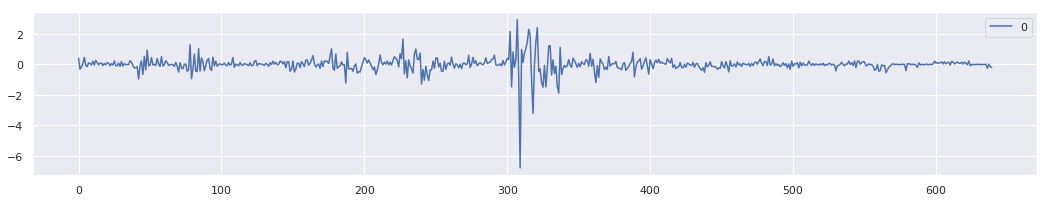

In [109]:
# line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

[(-2, 2)]

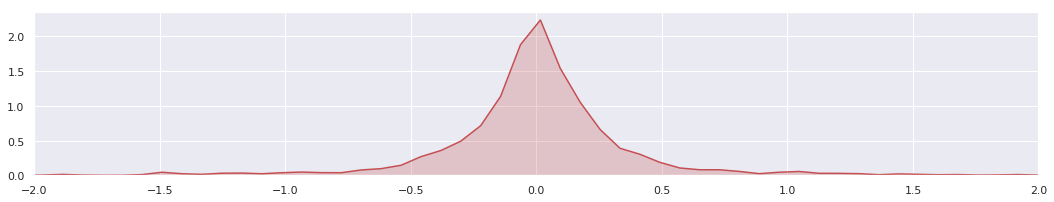

In [110]:
# density plot of residuals, using Seaborn kdeplot
sns.set(color_codes=True)
sns.kdeplot(np.hstack(residuals.values), shade=True, color="r").set(xlim=(-2, 2))

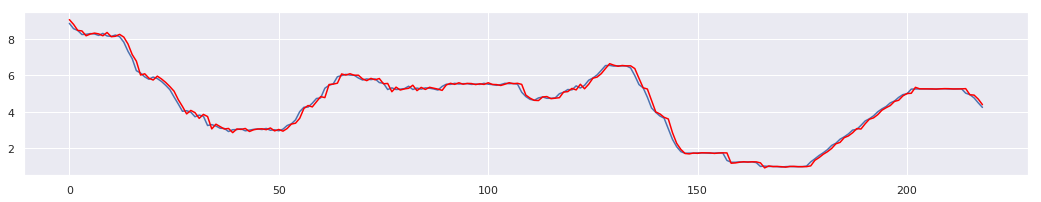

In [111]:
# plot forecasts against actual outcomes
plt.rc('figure', figsize=(18, 3))
plt.plot(test)
plt.plot(predictions, color='red')

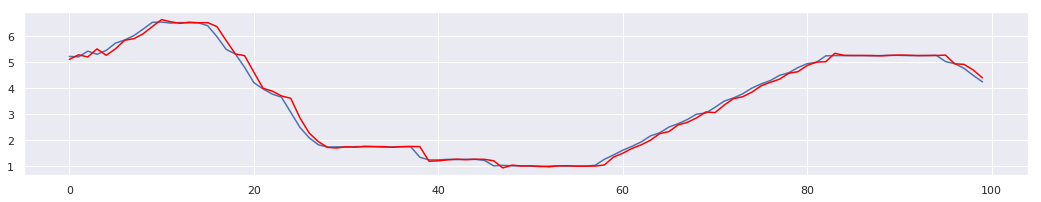

In [112]:
# zoom plot
plt.plot(test[-100:])
plt.plot(predictions[-100:], color='red')
plt.show()

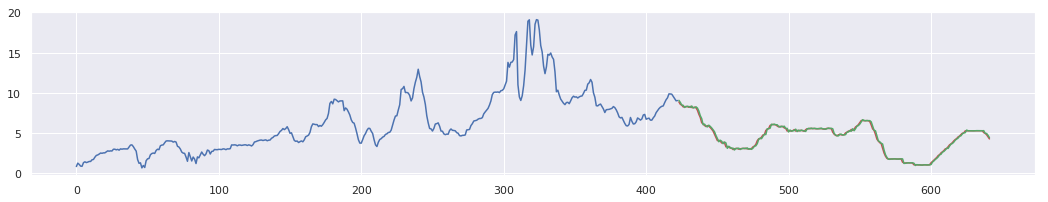

In [114]:
# plot train-test split of time series data
plt.plot(train)
plt.plot([None for i in train] + [x for x in test], color='r')
plt.plot([None for i in train] + [x for x in predictions], color='g')